## Calculating the analytical solution for the 2dV oscillating wave

Author: WaveHello <br>
Last Modified: 06/24/2024 <br>

**Purpose**: <br>
Setup the boundary conditions and run the xBeach model to recreate the oscillating basin model. This file will run the model that is in the same directory.

**Link to Smit (2008)** <br>
[Link](https://repository.tudelft.nl/islandora/object/uuid%3A416ae56c-8fa6-42b1-b532-acc457b28604)

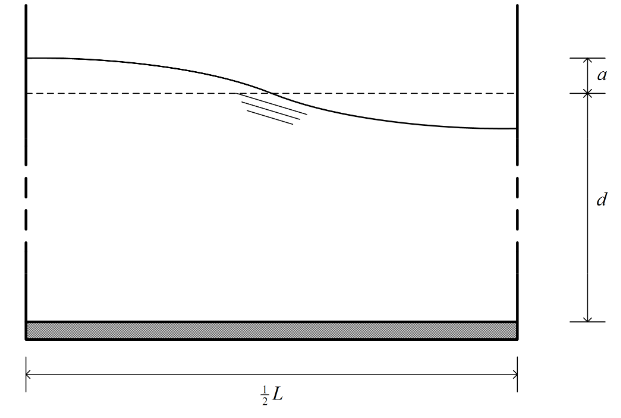

In [37]:
# import default modules
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from matplotlib import cm
import sys
import os
import subprocess

# Set global constants
PI = np.pi

# method to import xbtools with try routine
try:
    import xbTools
except ImportError:
    print('**no xbTools installation found in environment, adding parent path of notebook to see if it works')
    sys.path.append(r"C:\ERDC\xbeach-toolbox")

In [38]:
from xbTools.xbeachtools import XBeachModelSetup
from xbTools.xbeachpost import XBeachModelAnalysis
from xbTools.general.executing_runs import (generate_batch_script, 
                                            run_batch_script)

In [39]:
# Import library functions
sys.path.append(r"C:\ERDC\tutorial_models")
from lib.oscillating_basin_funcs import (calc_wave_number, calc_linear_wave_freq,
                                        calc_surface_elevation, calc_U_velocity, calc_V_velocity,
                                        )
from lib.os_functions import (write_2d_arr_2_file)
from lib.general_functions import find_closest_value_index

In [40]:
def create_directory_if_not_exists(directory_path):
    """
    Creates a directory if it does not already exist.
    
    Parameters:
    directory_path (str): The path of the directory to create.
    """
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created.")
    else:
        print(f"Directory '{directory_path}' already exists.")

def get_script_directory():
    try:
        # This will work if the script is run directly
        script_path = os.path.abspath(__file__)
    except NameError:
        # This will work in an interactive environment like Jupyter
        script_path = os.path.abspath('')
    
    return script_path

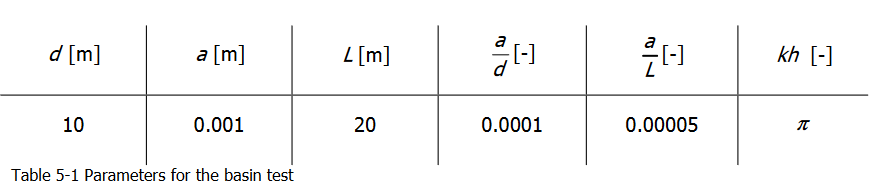

In [41]:
L = 20 / 2 # Length, [m]
g = 9.81 # gravity, [m/s^2]

relative_depth = np.pi # k/H 
d = 10                 # Still water depth, [m]
k = relative_depth/d   # wave number, [-/m]
amplitude = 0.001      # Amplitude of the wave

omega = calc_linear_wave_freq(k, g, d) # angular velocity, [rad/s]

# Calc the wave period
wave_period = 2 * np.pi / omega

print("Still water depth (d): {:.5f}".format(d))
print("Wave number: {:.3f}".format(k))
print("Depth: {:.3f}".format(d))
print("Angular Velocity: {:.3f}".format(omega))
print("Wave Period: {:.3f}".format(wave_period))

Still water depth (d): 10.00000
Wave number: 0.314
Depth: 10.000
Angular Velocity: 1.752
Wave Period: 3.586


### Setup the model directories

In [42]:
# Get the folder of the current script
script_dir = get_script_directory()

# Generate the model directory
model_dir = os.path.join(script_dir, f"")

create_directory_if_not_exists(model_dir)

exe_path = r"C:\ERDC\tutorial_models\XBeach_1.24.6057_Halloween_win64_netcdf\xbeach.exe"

# Make the batch file in the model dir
generate_batch_script(model_dir, exe_path, batch_file_name = "run_model.bat", 
                      include_cd = False, batch_file_folder = None)


batch_file_path = os.path.join(model_dir, "run_model.bat")

print("Script directory is: {}".format(script_dir))

Directory 'c:\ERDC\tutorial_models\oscillating_wave\1_oscillating_wave_nonh_1_layer\' already exists.
Script directory is: c:\ERDC\tutorial_models\oscillating_wave\1_oscillating_wave_nonh_1_layer


In [43]:
# Set bathy grid
nx = 100
num_analy_timestep = 1000

### Generate the mesh and initial water surface

In [44]:
# Set the CFL condition
CFL = 0.1

# Generate the x-mesh
xgr = np.linspace(0, L, nx+1)

# Set the y-mesh as none since the model is 1D
ygr = None

# Generate the bathymetry
floor_depth = -1 * d
zgr = np.ones(nx + 1) * floor_depth

In [45]:
model_time = 5 * wave_period

time = np.linspace(0, model_time, num_analy_timestep)

# Calc the initial surface elevation
init_surface_elev = calc_surface_elevation(amplitude, k, 0, xgr, 0, 0, omega)

# Calc the surface elevation at the start of the basin
boundary_eta = calc_surface_elevation(amplitude, k, 0, 0, 0, time, omega)

print("Model time: {}".format(model_time))

Model time: 17.928809539745043


In [46]:
zs_init_filename = "zsinitfile.txt"

zs_init_file_path = os.path.join(model_dir, zs_init_filename)

init_surface_elev = np.atleast_2d(init_surface_elev)
# Make the initial water surface elevation
write_2d_arr_2_file(init_surface_elev, zs_init_file_path)

2D array values have been written to c:\ERDC\tutorial_models\oscillating_wave\1_oscillating_wave_nonh_1_layer\zsinitfile.txt


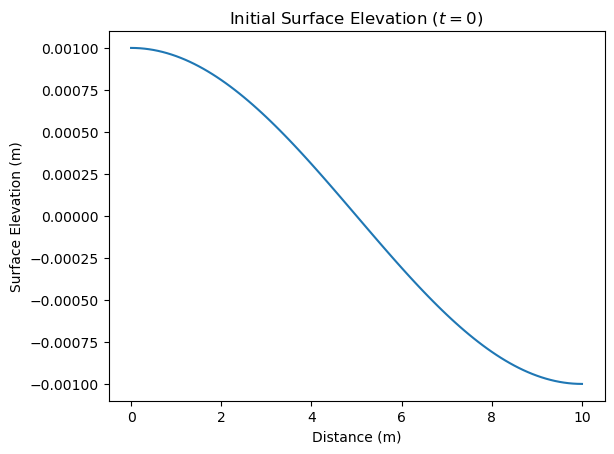

In [47]:
# Plot the inital surface elevation
plt.plot(xgr, init_surface_elev[0, :])

plt.xlabel("Distance (m)")
plt.ylabel("Surface Elevation (m)")

plt.title("Initial Surface Elevation ($t = 0$)")
plt.show()

### Create the model setup

Generating the model setup using the xBeach toolbox

In [48]:
xb_setup = XBeachModelSetup('test')

xb_setup.set_grid(xgr, ygr, zgr, posdwn=-1, alfa=0)
xb_setup.set_nebed(np.ones_like(zgr))
xb_setup.set_friction(np.ones_like(zgr))

In [49]:
xb_setup.set_params({"wbctype"      : "off",
                     'wavemodel'    : 'nonh',
                     "tideloc"      : 0,
                     'nonh'         : 1,
                     'CFL'          : CFL,
                    #  'nonhq3d'      : 1,
                    #  'nhlay'        : 0.33, 
                     'flow'         : 1,
                     'viscosity'    : 0, 
                     'lwave'        : 0, 
                     'bedfriccoef'  : 0.0,
                     'morphology'   : 0,
                     'zsinitfile'   : zs_init_filename,
                     'order'        : 1,
                     'ARC'          : 0, 
                     'front'        : "wall", 'back'         : "wall" ,
                     'left'         : "wall", 'right'        : "wall",

                     'tstop'        : model_time,
                     
                     "tintm"        : 0.1,
                     "tintp"        : 0.1,
                     "tintg"        : 0.1,
                     'nglobalvar'   : ['zs', 'zb', 'H'],
})


The following params were not found in the JSON: 
{'nonh': 1, 'flow': 1}


### Data
Generate and plot the bathymetry

In [50]:
xb_setup.write_model(model_dir, num_dec_dig=10)

In [51]:
run_batch_script(batch_file_path, flag_print_Blog = False)

Batch file 'c:\ERDC\tutorial_models\oscillating_wave\1_oscillating_wave_nonh_1_layer\run_model.bat' executed successfully.


In [52]:
results = XBeachModelAnalysis(fname = "foo", 
                              model_path=model_dir)

results.set_save_fig(False)
results.set_plot_localcoords(False)
results.set_plot_km_coords(False)

loading variable zs from file
loading variable zb from file
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded


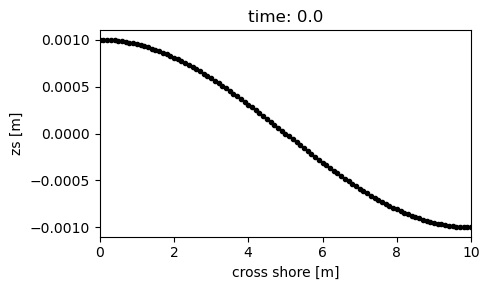

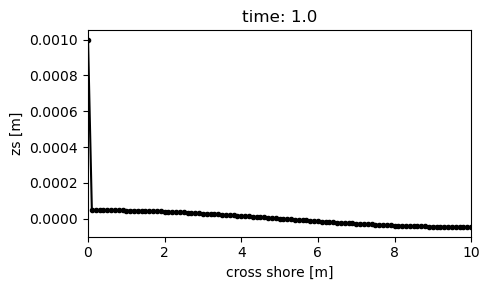

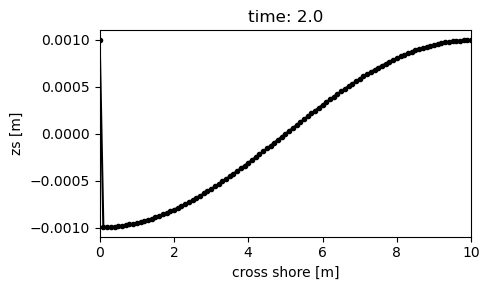

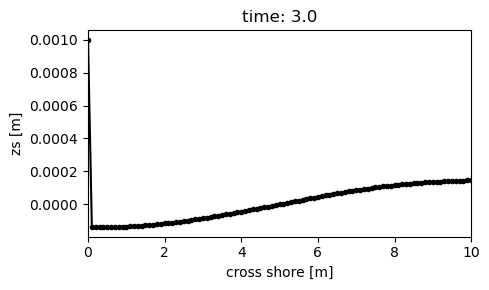

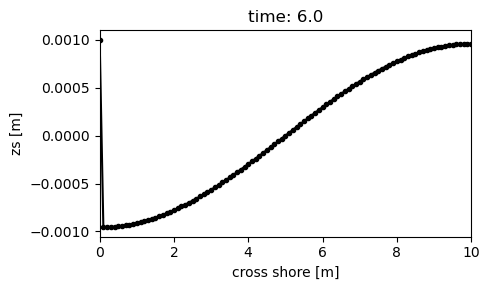

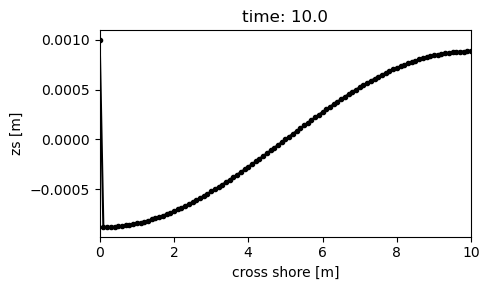

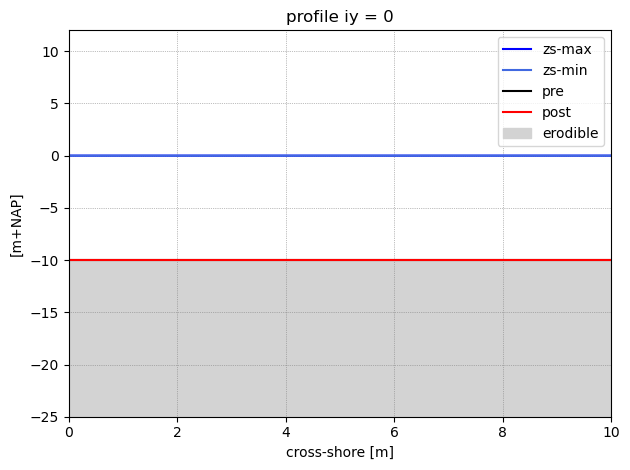

In [53]:
indices = [0, 10, 20, 30, 60, 100]

for index in indices:
    fig, ax = results.fig_cross_var('zs', index, iy=0, coord=None, plot_ref_bathy=False, zmin=-1)

fig, ax = results.fig_profile_change(iy=0)

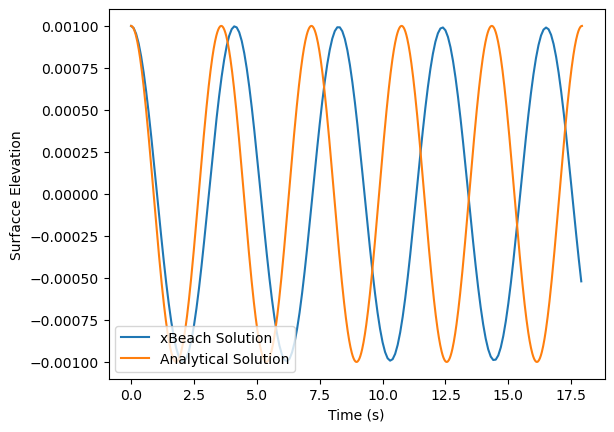

In [54]:
zs_model = results.var["zs"][:, 0, 1]
global_time = results.var["globaltime"]
plt.plot(global_time, zs_model, label = "xBeach Solution")

plt.plot(time, boundary_eta, label = "Analytical Solution")

plt.xlabel("Time (s)")
plt.ylabel("Surfacce Elevation")
plt.legend(loc = "lower left")
plt.show()